In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from scipy.stats import kurtosis, skew
import gc
import json
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 31.9 s, sys: 1.85 s, total: 33.7 s
Wall time: 31.7 s


In [6]:
train_df.shape

(11341042, 11)

## Feature Engineering

### Cleanup

In [7]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [8]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [9]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [10]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [11]:
comp_train_df = feature_engineering.feature_generation(train_samples, False,
                                                       assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                       list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                       list_of_title=list_of_title, win_code=win_code, 
                                                       activities_map=activities_map, 
                                                       list_of_event_code_world=list_of_event_code_world,
                                                       list_of_event_code_title=list_of_event_code_title,
                                                       list_of_event_id_world=list_of_event_id_world)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/fastai/fastai-exercises/nbs_gil/data_science_bowl/scripts/feature_engineering.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session["passed"] = session.loc[:, "timestamp"].diff().apply(lambda x: x.seconds)


In [12]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanMushroom Sorter (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,1cf54632,ab4ec3a4,67aa2ada,4a4c3d21,ec138c1c,499edb7c,6f4adc4b,88d4a5be,abc5811c,709b1251,2a444e03,17113b36,acf5c23f,53c6e11a,6c517a88,ea296733,51311d7a,1375ccb7,3ee399c3,b2e5b0f1,3dfd4aa4,14de4c5d,26fd2d99,71e712d8,7961e599,2a512369,9b4001e4,8ac7cce4,3b2048ee,7040c096,0086365d,9b23e8ee,31973d56,84b0e0c8,90ea0bac,0d18d96c,d185d3ea,d3640339,e79f3763,7ad3efc6,6f8106d9,7372e1a5,b1d5101d,d9c005dd,d02b7a8e,30614231,73757a5e,9de5e594,e5734469,87d743c1,74e5f8a7,26a5a3dd,15a43e5b,a592d54e,9d29771f,bd701df8,91561152,f6947f54,1beb320a,5b49460a,bb3e370b,36fa3ebe,84538528,ca11f653,f806dc10,5c3d2b2f,b74258a0,5a848010,a1bbe385,dcaede90,8af75982,d2e9262e,7d5c30a2,93b353f2,ad148f58,6d90d394,9ed8f6da,77ead60d,9ce586dd,e37a2b78,792530f8,8d748b58,bd612267,d06f75b5,3bfd1a65,8f094001,d45ed6a1,5290eab1,a5be6304,c58186bf,2c4e6db0,7cf1bc53,e4f1efe6,e57dd7af,44cb4907,86c924c4,13f56524,a52b92d5,08fd73f3,71fe8f75,ecc36b7f,7d093bf9,3d8c61b0,9e34ea74,e080a381,cdd22e43,611485c5,bfc77bd6,4ef8cdd3,04df9b66,37c53127,6043a2b4,56bcd38d,ac92046e,f93fc684,c277e121,33505eae,a76029ee,c1cac9a2,48349b14,3bb91ced,47efca07,a5e9da97,0db6d71d,4a09ace1,a6d66e51,e4d32835,c7fe2a55,e64e2cfd,cf7638f3,eb2c19cd,155f62a4,3323d7e9,28520915,f54238ee,bbfe0445,5de79a6a,5f0eb72c,5f5b2617,fcfdffb6,a8a78786,3edf6747,2dc29e21,392e14df,763fc34e,de26c3a6,857f21c0,731c0cbe,7fd1ac25,828e68f9,8d84fa81,4bb2f698,a7640a16,461eace6,d88e8f25,3afde5dd,29f54413,5859dfb6,c0415e5c,598f4598,2ec694de,1340b8d7,01ca3a3c,5d042115,b7530680,bdf49a58,77261ab5,46b50ba8,37ee8496,6077cc36,c7f7f0e1,dcb1663e,76babcde,90d848e0,56817e2b,d2659ab4,67439901,a44b10dc,e694a35b,e3ff61fb,e5c9df6f,37db1c2f,daac11b0,3bb91dda,ecaab346,56cd3b43,bcceccc6,df4940d3,532a2afb,b88f38da,0413e89d,3afb49e6,e7561dd2,2230fab4,16dffff1,df4fe8b6,29bdd9ba,d51b1749,5154fc30,65abac75,7423acbc,ab3136ba,3d0b9317,27253bdc,3ccd3f02,63f13dd7,3babcb9b,907a054b,9554a50b,25fa8af4,47026d5f,3a4be871,e7e44842,49ed92e9,17ca3959,dcb55a27,562cec5f,9e4c8c7b,d88ca108,85d1b0de,d3268efa,4d911100,cc5087a3,6bf9e3e1,c2baf0bd,06372577,5c2f29ca,8d7e386c,f56e0afc,c54cf6c5,a1e4395d,...,3120Pan Balance,3110Pan Balance,2000Treasure Map,2060Leaf Leader,3020Bird Measurer (Assessment),4090Cauldron Filler (Assessment),4070Cart Balancer (Assessment),2070Air Show,3010Pan Balance,2080Scrub-A-Dub,3010Scrub-A-Dub,2030Leaf Leader,4090All Star Sorting,4080Dino Dive,4090Bird Measurer (Assessment),4090Watering Hole (Activity),2030Dino Drink,2000Bird Measurer (Assessment),4110Air Show,2000Dino Drink,4080Fireworks (Activity),4220Bubble Bath,3110Bottle Filler (Activity),2030Happy Camel,4010Dino Drink,4030Mushroom Sorter (Assessment),4025Bird Measurer (Assessment),4022Flower Waterer (Activity),4090Egg Dropper (Activity),4080Mushroom Sorter (Assessment),4020Chest Sorter (Assessment),2000Tree Top City - Level 1,"2000Heavy, Heavier, Heaviest",2010Watering Hole (Activity),4020Cart Balancer (Assessment),3021Dino Dive,3110All Star Sorting,3120Dino Dive,4025Mushroom Sorter (Assessment),3021Chow Time,3121All Star Sorting,3010Cauldron Filler (Assessment),3021Scrub-A-Dub,3010Chest Sorter (Assessment),2010Mushroom Sorter (Assessment),3020Pan Balance,3020Cauldron Filler (Assessment),3010Dino Dive,3021All Star Sorting,4035Chow Time,2000Bubble Bath,3010Chicken Balancer (Activity),4020Egg Dropper (Activity),3121Crystals Rule,3010Fireworks (Activity),2070Dino Drink,4080Bird Measurer (Assessment),4045Bubble Bath,4090Dino Dive,3121Cauldron Filler (Assessment),3110Chest Sorter (Assessment),2000Slop Problem,3010Bottle Filler (Activity),2000Cauldr

In [13]:
extra_training = []
comp_test_df = feature_engineering.feature_generation(test_samples, True, extra_training=extra_training,
                                                      assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                      list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                      list_of_title=list_of_title, win_code=win_code, 
                                                      activities_map=activities_map,
                                                      list_of_event_code_world=list_of_event_code_world,
                                                      list_of_event_code_title=list_of_event_code_title,
                                                      list_of_event_id_world=list_of_event_id_world)

In [14]:
extra_training_df = pd.DataFrame(extra_training)
extra_training_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanMushroom Sorter (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,1cf54632,ab4ec3a4,67aa2ada,4a4c3d21,ec138c1c,499edb7c,6f4adc4b,88d4a5be,abc5811c,709b1251,2a444e03,17113b36,acf5c23f,53c6e11a,6c517a88,ea296733,51311d7a,1375ccb7,3ee399c3,b2e5b0f1,3dfd4aa4,14de4c5d,26fd2d99,71e712d8,7961e599,2a512369,9b4001e4,8ac7cce4,3b2048ee,7040c096,0086365d,9b23e8ee,31973d56,84b0e0c8,90ea0bac,0d18d96c,d185d3ea,d3640339,e79f3763,7ad3efc6,6f8106d9,7372e1a5,b1d5101d,d9c005dd,d02b7a8e,30614231,73757a5e,9de5e594,e5734469,87d743c1,74e5f8a7,26a5a3dd,15a43e5b,a592d54e,9d29771f,bd701df8,91561152,f6947f54,1beb320a,5b49460a,bb3e370b,36fa3ebe,84538528,ca11f653,f806dc10,5c3d2b2f,b74258a0,5a848010,a1bbe385,dcaede90,8af75982,d2e9262e,7d5c30a2,93b353f2,ad148f58,6d90d394,9ed8f6da,77ead60d,9ce586dd,e37a2b78,792530f8,8d748b58,bd612267,d06f75b5,3bfd1a65,8f094001,d45ed6a1,5290eab1,a5be6304,c58186bf,2c4e6db0,7cf1bc53,e4f1efe6,e57dd7af,44cb4907,86c924c4,13f56524,a52b92d5,08fd73f3,71fe8f75,ecc36b7f,7d093bf9,3d8c61b0,9e34ea74,e080a381,cdd22e43,611485c5,bfc77bd6,4ef8cdd3,04df9b66,37c53127,6043a2b4,56bcd38d,ac92046e,f93fc684,c277e121,33505eae,a76029ee,c1cac9a2,48349b14,3bb91ced,47efca07,a5e9da97,0db6d71d,4a09ace1,a6d66e51,e4d32835,c7fe2a55,e64e2cfd,cf7638f3,eb2c19cd,155f62a4,3323d7e9,28520915,f54238ee,bbfe0445,5de79a6a,5f0eb72c,5f5b2617,fcfdffb6,a8a78786,3edf6747,2dc29e21,392e14df,763fc34e,de26c3a6,857f21c0,731c0cbe,7fd1ac25,828e68f9,8d84fa81,4bb2f698,a7640a16,461eace6,d88e8f25,3afde5dd,29f54413,5859dfb6,c0415e5c,598f4598,2ec694de,1340b8d7,01ca3a3c,5d042115,b7530680,bdf49a58,77261ab5,46b50ba8,37ee8496,6077cc36,c7f7f0e1,dcb1663e,76babcde,90d848e0,56817e2b,d2659ab4,67439901,a44b10dc,e694a35b,e3ff61fb,e5c9df6f,37db1c2f,daac11b0,3bb91dda,ecaab346,56cd3b43,bcceccc6,df4940d3,532a2afb,b88f38da,0413e89d,3afb49e6,e7561dd2,2230fab4,16dffff1,df4fe8b6,29bdd9ba,d51b1749,5154fc30,65abac75,7423acbc,ab3136ba,3d0b9317,27253bdc,3ccd3f02,63f13dd7,3babcb9b,907a054b,9554a50b,25fa8af4,47026d5f,3a4be871,e7e44842,49ed92e9,17ca3959,dcb55a27,562cec5f,9e4c8c7b,d88ca108,85d1b0de,d3268efa,4d911100,cc5087a3,6bf9e3e1,c2baf0bd,06372577,5c2f29ca,8d7e386c,f56e0afc,c54cf6c5,a1e4395d,...,3120Pan Balance,3110Pan Balance,2000Treasure Map,2060Leaf Leader,3020Bird Measurer (Assessment),4090Cauldron Filler (Assessment),4070Cart Balancer (Assessment),2070Air Show,3010Pan Balance,2080Scrub-A-Dub,3010Scrub-A-Dub,2030Leaf Leader,4090All Star Sorting,4080Dino Dive,4090Bird Measurer (Assessment),4090Watering Hole (Activity),2030Dino Drink,2000Bird Measurer (Assessment),4110Air Show,2000Dino Drink,4080Fireworks (Activity),4220Bubble Bath,3110Bottle Filler (Activity),2030Happy Camel,4010Dino Drink,4030Mushroom Sorter (Assessment),4025Bird Measurer (Assessment),4022Flower Waterer (Activity),4090Egg Dropper (Activity),4080Mushroom Sorter (Assessment),4020Chest Sorter (Assessment),2000Tree Top City - Level 1,"2000Heavy, Heavier, Heaviest",2010Watering Hole (Activity),4020Cart Balancer (Assessment),3021Dino Dive,3110All Star Sorting,3120Dino Dive,4025Mushroom Sorter (Assessment),3021Chow Time,3121All Star Sorting,3010Cauldron Filler (Assessment),3021Scrub-A-Dub,3010Chest Sorter (Assessment),2010Mushroom Sorter (Assessment),3020Pan Balance,3020Cauldron Filler (Assessment),3010Dino Dive,3021All Star Sorting,4035Chow Time,2000Bubble Bath,3010Chicken Balancer (Activity),4020Egg Dropper (Activity),3121Crystals Rule,3010Fireworks (Activity),2070Dino Drink,4080Bird Measurer (Assessment),4045Bubble Bath,4090Dino Dive,3121Cauldron Filler (Assessment),3110Chest Sorter (Assessment),2000Slop Problem,3010Bottle Filler (Activity),2000Cauldr

In [15]:
comp_train_df = comp_train_df.append(extra_training_df, ignore_index=True).fillna(0)

In [16]:
comp_train_df.shape

(20273, 1005)

In [17]:
for del_field in ['timestamp', 'accuracy']:
    del comp_train_df[del_field]
    del comp_test_df[del_field]

In [18]:
comp_test_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,duration_std,duration_skew,duration_kurtosis,title_duration_meanChest Sorter (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanCart Balancer (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanMushroom Sorter (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,1cf54632,ab4ec3a4,67aa2ada,4a4c3d21,ec138c1c,499edb7c,6f4adc4b,88d4a5be,abc5811c,709b1251,2a444e03,17113b36,acf5c23f,53c6e11a,6c517a88,ea296733,51311d7a,1375ccb7,3ee399c3,b2e5b0f1,3dfd4aa4,14de4c5d,26fd2d99,71e712d8,7961e599,2a512369,9b4001e4,8ac7cce4,3b2048ee,7040c096,0086365d,9b23e8ee,31973d56,84b0e0c8,90ea0bac,0d18d96c,d185d3ea,d3640339,e79f3763,7ad3efc6,6f8106d9,7372e1a5,b1d5101d,d9c005dd,d02b7a8e,30614231,73757a5e,9de5e594,e5734469,87d743c1,74e5f8a7,26a5a3dd,15a43e5b,a592d54e,9d29771f,bd701df8,91561152,f6947f54,1beb320a,5b49460a,bb3e370b,36fa3ebe,84538528,ca11f653,f806dc10,5c3d2b2f,b74258a0,5a848010,a1bbe385,dcaede90,8af75982,d2e9262e,7d5c30a2,93b353f2,ad148f58,6d90d394,9ed8f6da,77ead60d,9ce586dd,e37a2b78,792530f8,8d748b58,bd612267,d06f75b5,3bfd1a65,8f094001,d45ed6a1,5290eab1,a5be6304,c58186bf,2c4e6db0,7cf1bc53,e4f1efe6,e57dd7af,44cb4907,86c924c4,13f56524,a52b92d5,08fd73f3,71fe8f75,ecc36b7f,7d093bf9,3d8c61b0,9e34ea74,e080a381,cdd22e43,611485c5,bfc77bd6,4ef8cdd3,04df9b66,37c53127,6043a2b4,56bcd38d,ac92046e,f93fc684,c277e121,33505eae,a76029ee,c1cac9a2,48349b14,3bb91ced,47efca07,a5e9da97,0db6d71d,4a09ace1,a6d66e51,e4d32835,c7fe2a55,e64e2cfd,cf7638f3,eb2c19cd,155f62a4,3323d7e9,28520915,f54238ee,bbfe0445,5de79a6a,5f0eb72c,5f5b2617,fcfdffb6,a8a78786,3edf6747,2dc29e21,392e14df,763fc34e,de26c3a6,857f21c0,731c0cbe,7fd1ac25,828e68f9,8d84fa81,4bb2f698,a7640a16,461eace6,d88e8f25,3afde5dd,29f54413,5859dfb6,c0415e5c,598f4598,2ec694de,1340b8d7,01ca3a3c,5d042115,b7530680,bdf49a58,77261ab5,46b50ba8,37ee8496,6077cc36,c7f7f0e1,dcb1663e,76babcde,90d848e0,56817e2b,d2659ab4,67439901,a44b10dc,e694a35b,e3ff61fb,e5c9df6f,37db1c2f,daac11b0,3bb91dda,ecaab346,56cd3b43,bcceccc6,df4940d3,532a2afb,b88f38da,0413e89d,3afb49e6,e7561dd2,2230fab4,16dffff1,df4fe8b6,29bdd9ba,d51b1749,5154fc30,65abac75,7423acbc,ab3136ba,3d0b9317,27253bdc,3ccd3f02,63f13dd7,3babcb9b,907a054b,9554a50b,25fa8af4,47026d5f,3a4be871,e7e44842,49ed92e9,17ca3959,dcb55a27,562cec5f,9e4c8c7b,d88ca108,85d1b0de,d3268efa,4d911100,cc5087a3,6bf9e3e1,c2baf0bd,06372577,5c2f29ca,8d7e386c,...,3120Scrub-A-Dub,2030Bubble Bath,4035All Star Sorting,3010Flower Waterer (Activity),4035Cauldron Filler (Assessment),3120Pan Balance,3110Pan Balance,2000Treasure Map,2060Leaf Leader,3020Bird Measurer (Assessment),4090Cauldron Filler (Assessment),4070Cart Balancer (Assessment),2070Air Show,3010Pan Balance,2080Scrub-A-Dub,3010Scrub-A-Dub,2030Leaf Leader,4090All Star Sorting,4080Dino Dive,4090Bird Measurer (Assessment),4090Watering Hole (Activity),2030Dino Drink,2000Bird Measurer (Assessment),4110Air Show,2000Dino Drink,4080Fireworks (Activity),4220Bubble Bath,3110Bottle Filler (Activity),2030Happy Camel,4010Dino Drink,4030Mushroom Sorter (Assessment),4025Bird Measurer (Assessment),4022Flower Waterer (Activity),4090Egg Dropper (Activity),4080Mushroom Sorter (Assessment),4020Chest Sorter (Assessment),2000Tree Top City - Level 1,"2000Heavy, Heavier, Heaviest",2010Watering Hole (Activity),4020Cart Balancer (Assessment),3021Dino Dive,3110All Star Sorting,3120Dino Dive,4025Mushroom Sorter (Assessment),3021Chow Time,3121All Star Sorting,3010Cauldron Filler (Assessment),3021Scrub-A-Dub,3010Chest Sorter (Assessment),2010Mushroom Sorter (Assessment),3020Pan Balance,3020Cauldron Filler (Assessment),3010Dino Dive,3021All Star Sorting,4035Chow Time,2000Bubble Bath,3010Chicken Balancer (Activity),4020Egg Dropper (Activity),3121Crystals Rule,3010Fireworks (Activity),2070Dino Drink,4080Bird Measurer (Assessment),4045Bubble Bath

## Normalize Column Titles

In [19]:
missing_train_columns = [c for c in list(comp_train_df.columns) if c != 'game_session' and c != 'accuracy_group' and c not in set(comp_test_df.columns)]
missing_train_columns

[]

In [20]:
comp_train_df = comp_train_df[[c for c in comp_train_df.columns if c not in missing_train_columns]]

In [21]:
missing_test_columns = [c for c in list(comp_test_df.columns) if c not in set(comp_train_df.columns)]
missing_test_columns

[]

In [22]:
comp_test_df = comp_test_df[[c for c in comp_test_df.columns if c not in missing_test_columns]]

In [23]:
comp_train_df.fillna(0, inplace=True)
comp_test_df.fillna(0, inplace=True)

In [24]:
### Remove zero columns

In [25]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

## Training

In [26]:
from fastai.tabular import *
from fastai import callbacks

In [27]:
dep_var = 'accuracy_group'
cat_names = ['session_title']
cont_names = [c for c in comp_train_df.columns if c not in ['accuracy_group', 'installation_id', 'game_session', 'event_id', 'session_title', 'timestamp']]
procs = [FillMissing, Categorify, Normalize]

In [37]:
from fastai.metrics import RegMetrics

def rounder(preds, coefs):
    y = preds.clone()
    y[y < coefs[0]] = 0
    y[y >= coefs[2]] = 3
    y[(y >= coefs[0]) & (y < coefs[1])] = 1
    y[(y >= coefs[1]) & (y < coefs[2])] = 2
    return y.type(torch.IntTensor)

def get_class_bounds(y, y_pred, N=4, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

class KappaScoreRegression(RegMetrics):
    def on_epoch_end(self, last_metrics, **kwargs):
        preds = self.preds.flatten()
        opt = feature_engineering.OptimizedRounder(get_class_bounds(self.targs, preds), labels=[0, 1, 2, 3])
        opt.fit(preds, self.targs)
        coefs = opt.coefficients()
        qwk = cohen_kappa_score(rounder(preds, coefs), self.targs, weights="quadratic")
        return add_metrics(last_metrics, qwk)

In [40]:
metrics = [KappaScoreRegression()]

In [41]:
def MyMSELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return FlattenedLoss(nn.SmoothL1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [42]:
class SaveBestCallback(callbacks.TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')
                if not hasattr(self.learn, 'best') or self.learn.best < current:
                    self.learn.best = current
                    self.learn.best_name = self.name
                    
    def on_train_end(self, **kwargs):
        "Load the best model."
        if hasattr(self.learn, 'best'):
            print(f'learn best {self.learn.best} {self.learn.best_name}')
            self.learn.load(self.learn.best_name)

In [43]:
# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = GroupKFold(n_splits=5)
y = comp_train_df['accuracy_group']

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.617007,0.625299,0.346523,00:04
1,0.577328,0.594327,0.378311,00:05
2,0.523451,0.519143,0.469487,00:05
3,0.500052,0.519806,0.467963,00:05
4,0.471716,0.472332,0.524270,00:05
5,0.463303,0.484208,0.518469,00:05
6,0.455782,0.471711,0.524647,00:05
7,0.440842,0.469726,0.528427,00:05
8,0.436370,0.460606,0.542889,00:04
9,0.414834,0.469510,0.529299,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.34652265937036564.
Better model found at epoch 1 with kappa_score_regression value: 0.37831149903765826.
Better model found at epoch 2 with kappa_score_regression value: 0.46948650211295906.
Better model found at epoch 4 with kappa_score_regression value: 0.5242697087565416.
Better model found at epoch 6 with kappa_score_regression value: 0.5246471030437634.
Better model found at epoch 7 with kappa_score_regression value: 0.5284271741554067.
Better model found at epoch 8 with kappa_score_regression value: 0.5428888655564098.
Better model found at epoch 11 with kappa_score_regression value: 0.549861907008038.
Epoch 19: early stopping
learn best 0.549861907008038 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.387422,0.465907,0.532477,00:04
1,0.386638,0.445014,0.553001,00:04
2,0.393093,0.460956,0.540095,00:05
3,0.389862,0.457368,0.540497,00:05
4,0.366031,0.456244,0.539317,00:04
5,0.381405,0.460027,0.535263,00:05
6,0.362643,0.462346,0.535129,00:05
7,0.382344,0.458039,0.537344,00:04
8,0.366453,0.460383,0.536289,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5324772320021356.
Better model found at epoch 1 with kappa_score_regression value: 0.5530012741939337.
Epoch 9: early stopping
learn best 0.5530012741939337 data_science_bowl_best_model_3


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.616640,0.605466,0.328563,00:05
1,0.576561,0.689123,0.265865,00:04
2,0.531508,0.517463,0.458663,00:05
3,0.486922,0.507677,0.445607,00:05
4,0.469407,0.468904,0.502817,00:05
5,0.450396,0.472891,0.497201,00:05
6,0.453824,0.495816,0.472752,00:04
7,0.442437,0.472934,0.507265,00:05
8,0.424216,0.460248,0.519984,00:05
9,0.411119,0.457709,0.529630,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.32856250575352064.
Better model found at epoch 2 with kappa_score_regression value: 0.4586631803431934.
Better model found at epoch 4 with kappa_score_regression value: 0.5028171323994162.
Better model found at epoch 7 with kappa_score_regression value: 0.5072646102454504.
Better model found at epoch 8 with kappa_score_regression value: 0.5199840370498645.
Better model found at epoch 9 with kappa_score_regression value: 0.5296295627280643.
Better model found at epoch 10 with kappa_score_regression value: 0.5335258174266617.
Better model found at epoch 11 with kappa_score_regression value: 0.544110580036411.
Epoch 19: early stopping
learn best 0.544110580036411 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.381469,0.452216,0.533986,00:05
1,0.370893,0.456551,0.528561,00:05
2,0.390394,0.450524,0.539307,00:05
3,0.363385,0.452458,0.535932,00:05
4,0.366009,0.453734,0.531133,00:05
5,0.375048,0.452713,0.533727,00:05
6,0.369671,0.457104,0.527328,00:05
7,0.363099,0.460578,0.522367,00:05
8,0.364795,0.455802,0.535089,00:05
9,0.352858,0.455396,0.538094,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5339861129558108.
Better model found at epoch 2 with kappa_score_regression value: 0.5393069266069794.
learn best 0.544110580036411 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.605464,0.610947,0.344897,00:05
1,0.601003,0.604137,0.372040,00:05
2,0.506288,0.511170,0.472672,00:04
3,0.486942,0.495636,0.494915,00:04
4,0.479438,0.494781,0.487226,00:05
5,0.452523,0.453201,0.541538,00:04
6,0.462665,0.460798,0.537135,00:05
7,0.438356,0.457378,0.543392,00:04
8,0.430126,0.499060,0.497492,00:05
9,0.420426,0.451634,0.543233,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.3448965338046962.
Better model found at epoch 1 with kappa_score_regression value: 0.3720397305924482.
Better model found at epoch 2 with kappa_score_regression value: 0.472672226506588.
Better model found at epoch 3 with kappa_score_regression value: 0.49491461285479554.
Better model found at epoch 5 with kappa_score_regression value: 0.5415380002940581.
Better model found at epoch 7 with kappa_score_regression value: 0.5433917199745528.
Better model found at epoch 11 with kappa_score_regression value: 0.5496774704439119.
Better model found at epoch 14 with kappa_score_regression value: 0.5506701374730285.
learn best 0.5506701374730285 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.361948,0.450830,0.539333,00:05
1,0.366296,0.449581,0.543164,00:05
2,0.356824,0.448609,0.546580,00:05
3,0.362345,0.452779,0.541534,00:05
4,0.351854,0.448577,0.544642,00:05
5,0.354072,0.455806,0.535689,00:04
6,0.358628,0.450598,0.541123,00:05
7,0.354035,0.454647,0.544985,00:05
8,0.355057,0.451935,0.539465,00:04
9,0.363948,0.456581,0.537636,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5393332712543067.
Better model found at epoch 1 with kappa_score_regression value: 0.5431637874050832.
Better model found at epoch 2 with kappa_score_regression value: 0.5465799181581699.
learn best 0.5506701374730285 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.614257,0.603411,0.349896,00:05
1,0.575243,0.628787,0.300074,00:05
2,0.525649,0.512886,0.467873,00:05
3,0.477573,0.515093,0.484063,00:05
4,0.471890,0.490241,0.503044,00:05
5,0.449068,0.480890,0.511235,00:04
6,0.450846,0.481657,0.503639,00:05
7,0.437925,0.475229,0.514455,00:05
8,0.428080,0.467879,0.531839,00:05
9,0.420446,0.477944,0.518697,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.3498956720301373.
Better model found at epoch 2 with kappa_score_regression value: 0.46787344244894313.
Better model found at epoch 3 with kappa_score_regression value: 0.4840626410306843.
Better model found at epoch 4 with kappa_score_regression value: 0.5030443996987337.
Better model found at epoch 5 with kappa_score_regression value: 0.5112345233655611.
Better model found at epoch 7 with kappa_score_regression value: 0.5144550992607326.
Better model found at epoch 8 with kappa_score_regression value: 0.531839275519518.
Epoch 16: early stopping
learn best 0.531839275519518 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.412986,0.473012,0.532454,00:05
1,0.405397,0.467044,0.527167,00:05
2,0.392935,0.470133,0.526333,00:05
3,0.393337,0.462544,0.535013,00:04
4,0.383729,0.465550,0.532541,00:05
5,0.382040,0.467387,0.528748,00:05
6,0.390639,0.464547,0.527514,00:05
7,0.389155,0.468270,0.525765,00:05
8,0.378580,0.466702,0.527330,00:05
9,0.378635,0.466559,0.527105,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5324538108061352.
Better model found at epoch 3 with kappa_score_regression value: 0.5350128442564153.
learn best 0.5350128442564153 data_science_bowl_best_model_3


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.619581,0.624528,0.355547,00:05
1,0.592750,0.586755,0.385269,00:05
2,0.520668,0.550503,0.431767,00:05
3,0.489577,0.495839,0.461973,00:05
4,0.471853,0.501836,0.462466,00:05
5,0.452033,0.464262,0.514410,00:05
6,0.452465,0.476444,0.487603,00:05
7,0.434041,0.461264,0.515425,00:05
8,0.428791,0.452798,0.524261,00:05
9,0.411302,0.459304,0.520661,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.3555466979864933.
Better model found at epoch 1 with kappa_score_regression value: 0.3852692399858839.
Better model found at epoch 2 with kappa_score_regression value: 0.4317670399684054.
Better model found at epoch 3 with kappa_score_regression value: 0.4619728792024502.
Better model found at epoch 4 with kappa_score_regression value: 0.462465671855416.
Better model found at epoch 5 with kappa_score_regression value: 0.514410351803011.
Better model found at epoch 7 with kappa_score_regression value: 0.5154248371010474.
Better model found at epoch 8 with kappa_score_regression value: 0.5242609401316698.
Epoch 16: early stopping
learn best 0.5242609401316698 data_science_bowl_best_model_2


epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.404810,0.450477,0.526517,00:05
1,0.394346,0.446865,0.531408,00:05
2,0.401379,0.453709,0.511169,00:05
3,0.399381,0.447871,0.535428,00:05
4,0.401301,0.455951,0.519916,00:05
5,0.397300,0.444538,0.532184,00:05
6,0.388722,0.452787,0.520069,00:05
7,0.386252,0.457871,0.525202,00:05
8,0.383705,0.455308,0.515571,00:05
9,0.379513,0.448080,0.529263,00:05


Better model found at epoch 0 with kappa_score_regression value: 0.5265171070296741.
Better model found at epoch 1 with kappa_score_regression value: 0.5314078878087412.
Better model found at epoch 3 with kappa_score_regression value: 0.535428332551402.
learn best 0.535428332551402 data_science_bowl_best_model_3


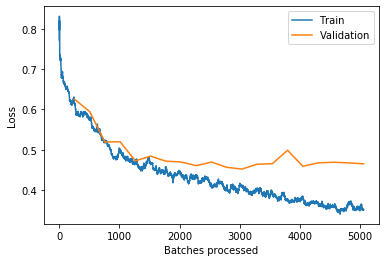

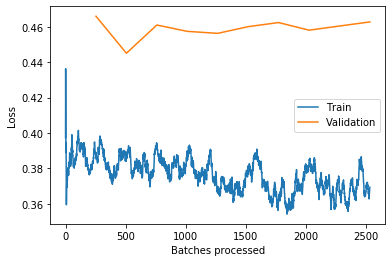

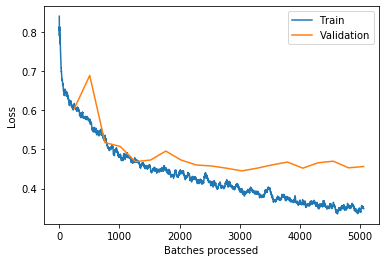

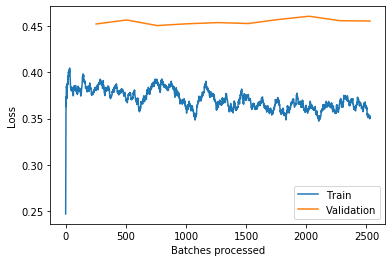

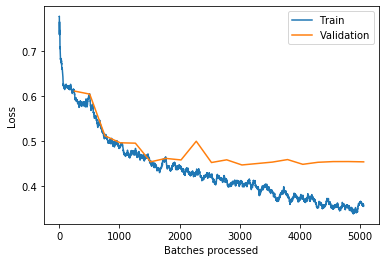

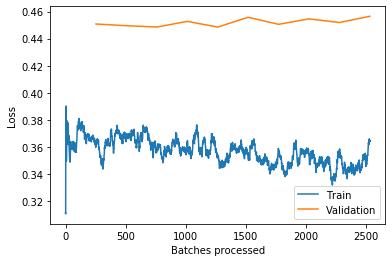

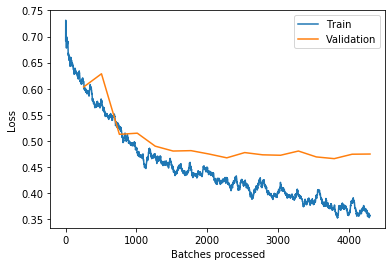

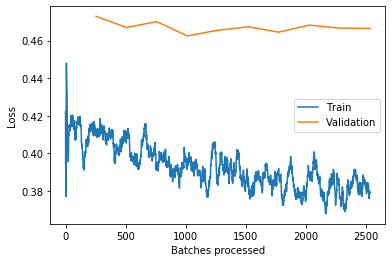

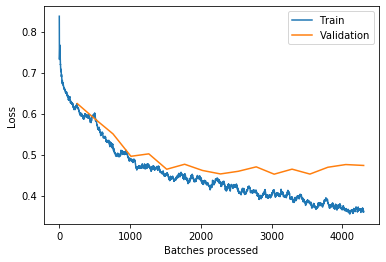

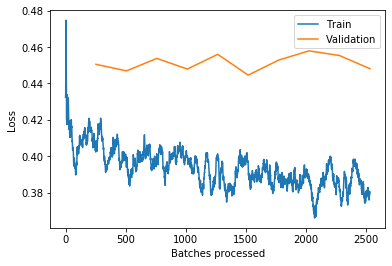

In [44]:
lr = 1e-03
learners = []

for train_index, val_index in folds.split(comp_train_df, y, comp_train_df['installation_id']):
    test_data = TabularList.from_df(comp_test_df, cat_names=cat_names, cont_names=cont_names)
    data = (TabularList.from_df(comp_train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idxs(train_index, val_index)
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test_data)
                           .databunch())
    learn = tabular_learner(data, layers=[10000, 1000, 100], y_range=[0, 3], metrics=metrics)
    learn.loss_func = MyMSELossFlat()
    learn.model_dir = Path('/kaggle/model')
    learn.fit_one_cycle(20, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                      SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', 
                                                       name='data_science_bowl_best_model_2')])
#     lr_find(learn)
#     learn.recorder.plot()
    learn.recorder.plot_losses()
    learn.fit_one_cycle(10, lr / 10, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                            SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', name='data_science_bowl_best_model_3')])
    learn.recorder.plot_losses()
    learners.append(learn)

In [38]:
learn_bests = [learn.best for learn in learners]
learn_bests

[0.556379502409525,
 0.5497172071107904,
 0.5610943617971044,
 0.5314335000460356,
 0.5281956203419389]

In [39]:
np.array(learn_bests).mean()

0.5453640383410788

## Inference

In [45]:
preds_train, y = learn.get_preds(ds_type=DatasetType.Valid)

[tensor([[0.1877],
         [0.4271],
         [2.3511],
         ...,
         [2.2895],
         [1.6540],
         [1.1978]]), tensor([0., 0., 1.,  ..., 3., 0., 3.])]

In [36]:
all_labels = []
all_coeffs = []
for learn in learners:
    preds_train, y = learn.get_preds(ds_type=DatasetType.Valid)
    labels_train = preds_train.flatten()
    opt = feature_engineering.OptimizedRounder(get_class_bounds(y, labels_train), labels=[0, 1, 2, 3])
    opt.fit(labels_train, y)
    coefs = opt.coefficients(); coefs
    all_coeffs.append(coefs)
    preds, y = learn.get_preds(ds_type=DatasetType.Test)
    labels = preds.flatten()
    all_labels.append(rounder(labels, coefs))

In [37]:
for labels in all_labels:
    print(pd.Series(labels).value_counts(normalize=True))

3    0.510
2    0.229
0    0.162
1    0.099
dtype: float64
3    0.405
2    0.289
0    0.183
1    0.123
dtype: float64
3    0.555
0    0.176
2    0.159
1    0.110
dtype: float64
3    0.415
2    0.317
0    0.142
1    0.126
dtype: float64
3    0.459
2    0.232
0    0.175
1    0.134
dtype: float64


In [38]:
# Average out all predictions
all_labels[0].shape[0]
all_labels_torch = torch.zeros([len(all_labels), all_labels[0].shape[0]])
for i, labels in enumerate(all_labels):
    all_labels_torch[i] = labels

In [39]:
all_labels_mean = all_labels_torch.mean(dim=0).round().int()

### Data Checks

In [40]:
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
valid_value_counts = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy_group'].value_counts(normalize=True)
valid_value_counts

3    0.457279
0    0.282816
1    0.133413
2    0.126492
Name: accuracy_group, dtype: float64

In [41]:
pd.Series(all_labels_mean).value_counts(normalize=True)

3    0.463
2    0.258
0    0.163
1    0.116
dtype: float64

## Submission

In [42]:
submission_df = pd.DataFrame({'installation_id': comp_test_df['installation_id'], 'accuracy_group': all_labels_mean})
submission_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,1


In [43]:
def prepare_submission(submission_df):
    sample_submission_df = pd.read_csv(path/'sample_submission.csv')
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(submission_df, on = 'installation_id')
    sample_submission_df = sample_submission_df[['installation_id', 'accuracy_group']]
    sample_submission_df.to_csv('submission.csv', index = False)

In [44]:
prepare_submission(submission_df)

In [45]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,2
02256298,3
0267757a,2
027e7ce5,2
02a29f99,0


In [46]:
!cat submission.csv | wc -l

1001
